# Goal of this python notebook

In this python notebook, we see that a DL model is able to predict $ λ$ , which characterizes the metric of 2+1 AdS, $$ ds^2 = -(1+λ^2 r^2)dt^2 + \frac{dr^2}{1+ λ^2 r^2} + dϕ^2,
$$ by a simulation using $(t, \phi)$ images of  free particles geodesics.

# Import library

We first import some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import  Conv2D
from keras.layers.pooling import  MaxPooling2D

# Mounting the google drive

To save the dataset we will generate, we utilize the google drive in this notebook. So we have to mount the google drive.

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Generate data

We first generate $(t,\phi)$ images of geodesics using the solution of the equation of motion of free particles in 2+1 AdS,
$$ r = \frac{1}{λ} \sqrt{E - \sqrt{E^2 - λ^2 L^2} \sin2 λ \tau},$$
$$\phi = \pm \arctan \left[  \frac{E}{\lambda L} \left( \tan λ \tau - \sqrt{1 - \left( \frac{λ L }{E}\right)^2} \right)\right] + \phi_0, $$
$$ t = \frac{1}{\lambda} \arctan \left[ \frac{(1+E)\tanλ\tau - \sqrt{E^2 - λ^2 L^2}}{\sqrt{1+2E+λ^2 L^2}} \right] + t_0 ,$$
where $E$  is a positive constant associated with energy, $L$ is a real constant associated with angular momentum, and
$t_0$ $(ϕ_0)$ is an integration constant for $t (ϕ )$.

We generate $E$, $L$, $t_0$ and $\phi_0$ at random. We set the range of them to 
$ 0 \leq E < 10$, $0 \leq L < \frac{E}{λ}$ , $ 0 \leq \phi_0 <2 \pi$ and $ 0 \leq t_0 <2 \pi$.

In [3]:
def generate_3d_initial_state(num_particle,lambda0):
  # num_particle means the number of particles/trajectories in one image.
  # lambda0 means the value of lambda in 2+1 AdS metric.

  E_rand = np.random.rand(num_particle)*10  # E_rand represents E.
  L_rand =  np.random.rand(num_particle)* E_rand / lambda0 # L_rand represents L.
  phi_rand = np.random.rand(num_particle)* 2 *np.pi #phi_rand represents \phi_0.
  time_rand = np.random.rand(num_particle)* 2 * np.pi #time_rand represents t_0.
  
  return E_rand,L_rand,phi_rand,time_rand


Because the solution of $t$ contains $\arctan$ and it is not a single-valued function, we define a function to calculate the solution of $t$.

In [4]:
def time_arctan(t,E,L,lambda0):
  # In the code, "t" represents the proper time and "time" means the coordinate time.
  X = (lambda0 ** 2) * (L ** 2)
#calculating coordinate time   
  time = 1 / lambda0 * np.arctan( ((1 + E ) * np.tan(lambda0 * t) - np.sqrt(E ** 2  - X )  )/ np.sqrt( 2 * E + X + 1 )  )  + 1/lambda0 * np.floor( (lambda0 * t + (np.pi / 2))/ np.pi ) * np.pi
    #Due to arctan ranging from -pi/2 to pi/2, the second term is needed to extend the coordinate time range
  return time


We calculate the geodesic of one particle using the solution of the equation of motion. 

In [5]:
def time_evolve_3d(t,E,L,lambda0,phi0,time0):
  # time0 and phi0 are the initial values of coordinate time and \phi.
    
  r = 1 / lambda0 *  np.sqrt(E - np.sqrt(E ** 2 - (lambda0 ** 2) * (L ** 2) ) * np.sin(2 * lambda0 * t) )
  Y = E * ( np.sin(lambda0 * t) -  np.sqrt(1- (lambda0 * L / E)**2 )*np.cos(lambda0 * t)  )
  X = lambda0 * L* np.cos(lambda0 * t)
  phi = np.arctan2(Y,X) + phi0
  phi = np.mod(phi,2*np.pi)
  time = time_arctan(t,E,L,lambda0) + time0

  return r,phi,time

We make numpy arrays which are utilized to get one image.

In [6]:
def generate_one_3d_rawdata(num_particle,lambda0):

  delta_tau = 0.01 #delta_tau represents the slice of \tau.
  # Because \tau is the argument of trigonometric functions sin(2 \lambda \tau) and tan(\lambda \tau), we can set the range of $\tau$ to $ 0 \leq \tau < 2\pi.
  # tau_frame is the number of frames.
  tau_frame = int(np.ceil(2*np.pi / delta_tau))

  E_rand, L_rand,phi_rand,time_rand = generate_3d_initial_state(num_particle,lambda0)

  #\phi has a freedom of sign and we assign the sign by binomial random variables. 
  sign_phi = np.random.binomial(1,0.5,size=num_particle)
  
  raw_data_array = np.zeros([num_particle,3,tau_frame])
  #raw_data_array is used to memorize the geodesics. 

  for i in range(0,tau_frame): 
    # i is the counter for the frame number.
      for j in range(num_particle):
        # j is the counter for the particle number.
        r, phi, time = time_evolve_3d(i * delta_tau, E_rand[j],L_rand[j],lambda0,phi_rand[j],time_rand[j])
        raw_data_array[j,0,i] = r
        raw_data_array[j,1,i] = phi * ( (-1) ** sign_phi[j] )
        raw_data_array[j,2,i] = time 

  return raw_data_array
 

We define a function which generates dateset as numpy arrays.
We set λ to be discretized and an integer between 1 and 4 for simplicity in the simulation.

In [7]:
def generate_dataset(num_data,num_particle):

  # we prepare two variables data_x and data_y.
  # data_x contains the solution of EOM. data_y contains the values of \lambda.
  data_x = []
  data_y = np.random.randint(1,5,(num_data,1)) # 1 <= \lambda <5 to avoid singularity 
  
  for i in range(num_data):
    x = generate_one_3d_rawdata(num_particle,data_y[i])
    data_x.append(x)
    

  data_x = np.array(data_x) #[data_number,particle_number,coordinate,proper_time]

  return data_x,data_y


We set num_particle = 10  and num_data = 4000 and generate dataset as numpy array using functions we defines above.

In [8]:
#setting parameters
num_particle = 10
num_data = 4000

# generating dataset as numpy array
data_x, data_y = generate_dataset(num_data,num_particle)


We save the dataset numpy array in the google drive. Note that you may have to replace the file path '/Colab Notebooks/metric_detector/3d_raw_array' ,where the dataset array is saved, according to your folder structure. 

In [25]:
#saving the data in npz file
# replacing the file path accodring to your coding environment.
file_path = "/content/drive/My Drive/Colab Notebooks/metric_detecter_public"
# You can replace the  "/3d_raw_array" to your favorite name of npz file.
np.savez_compressed(file_path + '/3d_raw_array', data_x,data_y)

# Making images

We make $(t, \phi)$ image dataset from the dataset array we generated.

In [26]:
#reloading the data from npz file
# replacing the file path accodring to your coding environment.
file_path = "/content/drive/My Drive/Colab Notebooks/metric_detecter_public"
dataset_array = np.load(file_path + '/3d_raw_array.npz')
data_x = dataset_array["arr_0"]
data_y = dataset_array["arr_1"]

In [27]:
def numpyarray_to_time_phi_image(t_array,phi_array):

  #setting the number of pixels in a image.
  pixel_num = 200

  #obtaining the maximum value and the minimum value of the coordinate time.
  t_max = np.max(t_array)
  t_min = np.min(t_array)

  #setting up the time boundary 
  h = t_max - t_min + 0.01 

  #delta_x and delta_y represent the slice of images.
  delta_x = 6.3 / pixel_num  #6.3 comes from 2 * np.pi
  delta_y = h/pixel_num 
  
  #obtaining the number of images.
  num_data = len(t_array)

  #preparing xy_image to save a (t,\phi) image.
  xy_image = np.zeros([num_data,pixel_num, pixel_num,1])

  for i in range(num_data):
    temp_x = phi_array[i,:,:].reshape(-1)
    temp_y = t_array[i,:,:].reshape(-1)

    #discretizing \phi and t by delta_x and delta_y
    for x,y in zip(temp_x,temp_y):
      xy_image[i,int(np.floor(x/delta_x)), int(np.floor((y - t_min)/delta_y)),0] = 1 #setting 0 while y=t_min

  return xy_image


In [28]:
t_array = data_x[:,:,2,:]
phi_array = data_x[:,:,1,:]
xy_image = numpyarray_to_time_phi_image(t_array,phi_array)

In [29]:
# making the target label. Subtracting 1 from the value of lambda for later convenience in converting data_y to  one-hot vectors.
data_y = np.squeeze(data_y) - 1

Let's print some images of the dataset.

value of lambda: 2


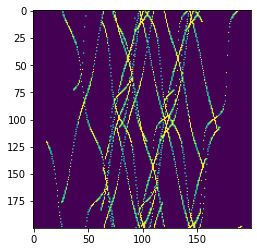

value of lambda: 1


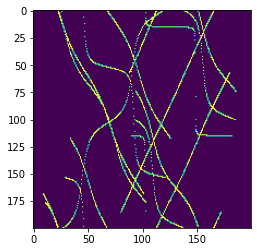

value of lambda: 4


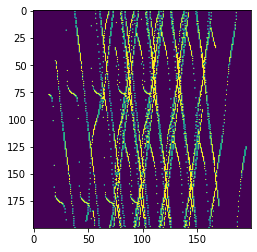

value of lambda: 2


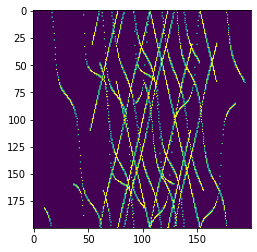

value of lambda: 2


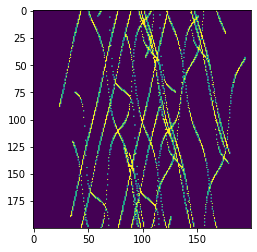

In [30]:
for i in range(5):
  plt.imshow(xy_image[i,:,:,0])
  print("value of lambda:",data_y[i]+1)
  plt.show()

# Training a DL model

Here, we train a CNN model using the dataset.

We split dataset into training data, validation data and test data.

In [31]:
num_data = 4000
# We generated 2800 training data, 800 validation data and 400 test data.
train_index = int(0.7*num_data)
vali_index = int(0.9 *num_data)

# convert  target labels to ont-hot vectors
y_one_hot = np_utils.to_categorical(data_y)

x_train = xy_image[:train_index,:,:,:]
y_train = y_one_hot[:train_index]
x_vali = xy_image[train_index:vali_index,:,:,:]
y_vali = y_one_hot[train_index:vali_index]
x_test = xy_image[vali_index:,:,:,:]
y_test = y_one_hot[vali_index:]
input_shape = xy_image[0,:,:,:].shape

We consider the following CNN structure.

In [32]:
model = Sequential()
model.add(Conv2D(5, (5,5), strides=(1, 1), input_shape=input_shape,padding='same', dilation_rate=(1, 1),activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(5, (5,5), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(5, (3,3), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(3, (3,3), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(2, (2,2), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(10,activation='tanh'))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 5)       130       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 67, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 5)         630       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 5)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 5)         230       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 5)          0

The loss function of this task is the categorical crossentropy and we use ADAM as a optimizer. We train the model for 150 epochs.

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=50,
                    epochs=150,
                    verbose=1,
                    validation_data=(x_vali, y_vali))
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/150
56/56 [==============================] - 12s 20ms/step - loss: 1.3172 - accuracy: 0.3471 - val_loss: 1.1014 - val_accuracy: 0.6050
Epoch 2/150
56/56 [==============================] - 1s 12ms/step - loss: 0.9201 - accuracy: 0.6104 - val_loss: 0.6823 - val_accuracy: 0.7487
Epoch 3/150
56/56 [==============================] - 1s 12ms/step - loss: 0.6824 - accuracy: 0.7204 - val_loss: 0.5299 - val_accuracy: 0.8050
Epoch 4/150
56/56 [==============================] - 1s 12ms/step - loss: 0.5409 - accuracy: 0.7907 - val_loss: 0.4288 - val_accuracy: 0.8363
Epoch 5/150
56/56 [==============================] - 1s 13ms/step - loss: 0.4684 - accuracy: 0.8179 - val_loss: 0.3692 - val_accuracy: 0.8725
Epoch 6/150
56/56 [==============================] - 1s 12ms/step - loss: 0.3980 - accuracy: 0.8636 - val_loss: 0.3146 - val_accuracy: 0.8963
Epoch 7/150
56/56 [==============================] - 1s 13ms/step - loss: 0.3607 - accuracy: 0.8711 - val_loss: 0.3243 - val_accuracy: 0.8700
Epoch

We check the value of the loss function for test data and plot how loss functions for training data and validation data change as the model learnes.

The loss function for test data: 0.0004757186397910118


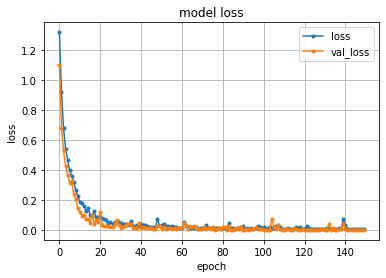

In [38]:
print('The loss function for test data:', score[0])
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

We also check how the model accuracy varies.

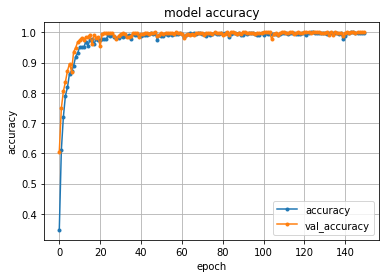

In [39]:
plt.plot(history.history['accuracy'], marker='.', label='accuracy')
plt.plot(history.history['val_accuracy'], marker='.', label='val_accuracy')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

We see the model accuracy for test data. 

In [40]:
print('The accuracy for test data:', score[1])

The accuracy for test data: 1.0


Let's print some results of the predicting of DL. The title of each image shows the prediction and the blue (red) color of the title means the correct (incorrect) prediction. DL returns right answers for almost all images.

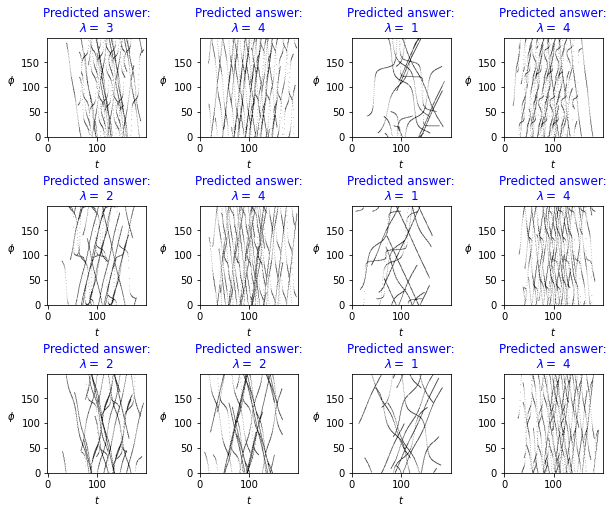

In [41]:
# calculate the prediction for test data
y_pred_one_hot = model.predict(x_test)
max_pred_index = np.argmax(y_pred_one_hot, axis=1)
max_test_index = np.argmax(y_test, axis=1)

# we print some images with prediction values.
num_rows = 3
num_cols = 4
plt.figure(figsize=(10,8))
plt.subplots_adjust( wspace = 0.5,hspace=0.7)
k = 0
plot_index = 1
for i in range(num_rows):
  for j in range(num_cols):
    plt.xlabel(r"$t$")
    plt.ylabel(r"$\phi$",rotation = "horizontal",labelpad=10)
    plt.subplot(num_rows,num_cols,plot_index)
    plt.imshow(x_test[k,:,:,0],cmap=plt.cm.gray_r,origin = "lower") 
    if max_pred_index[k] == max_test_index[k]:
      title_color = "blue"
    else:
      title_color = "red"
    plt.title(f"Predicted answer:\n"r"$\lambda =$ " f"{max_pred_index[k]+1}",color=title_color)
    k += 1
    plot_index += 1